Author: Jonathan Gong

In [117]:
import pandas as pd
import os
import sys
import sktime
from sktime.annotation.hmm_learn import GMMHMM 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Data processing

##### Data Loading

In [118]:
# Load one of the CSV files to inspect its columns
sample_file = pd.read_csv('../data/raw/500030_2024-07-01_2024-09-30.csv')


In [119]:
csv_files = []
for file in os.listdir('../data/raw'):
    if file.endswith('.csv'):
        csv_files.append(pd.read_csv(f'../data/raw/{file}', dtype={'template': 'str'}))

#### Data Processing

In [120]:
def dataprocessing(csv_files):

    # Extract the date, bgl, and msg_type columns from each CSV file
    each_bgl =[]
    for file in csv_files:
        each_df = file[["date", "bgl", "msg_type"]]
        each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
        each_df['date'] = each_df['date'].fillna(method='ffill')
        each_df['bgl'] = each_df['bgl'].fillna(method='ffill')
        each_df["msg_type"] = [
        1 if i == 'INTERVENTION_SNACK' else 2 if i == 'ANNOUNCE_MEAL' else 0
        for i in each_df["msg_type"]
        ]
        each_df = each_df.sort_values('date')
        # each_df.drop_duplicates(subset=['date'], inplace = True)
        # each_df.set_index('date', inplace=True)
        each_bgl.append(each_df)

    # Extract the date, time, and day columns from each df and split them into seperate days
    days_patients = []
    for bgl in each_bgl:
        # (hour:minute:second)
        bgl['time'] = bgl['date'].dt.time
        # (year-month-day)
        bgl['day'] = bgl['date'].dt.date
        # unique days
        unique_days = bgl['day'].unique()
        day_data = []
        for i, day in enumerate(unique_days):
            bgl_day = bgl[bgl['day'] == day]
            day_data.append(bgl_day[["date", "bgl"]])

        days_patients.append(day_data)

    # set index to date
    for patient_days in days_patients:
        for df in patient_days:
            df.set_index('date', inplace=True)

    # Scale BGL data
    patients_scaled = []
    scaler = StandardScaler()
    for patient_days in days_patients:
        scaled_data = scaler.fit_transform(pd.concat(patient_days))
        patients_scaled.append(scaled_data)
    
    # Normalize BGL data
    # patients_normalized = []
    # for patient_days in days_patients:
    #     print(pd.concat(patient_days))
    #     norm_data = pd.concat(patient_days)/max(pd.concat(patient_days))
    #     patients_normalized.append(norm_data)

    # Make ground truth labels for BGL data
    patients_labels = []
    for bgl in each_bgl:
        patients_labels.append(bgl[["msg_type"]])

    # return days_patients, patients_scaled, patients_normalized, patients_labels
    return days_patients, patients_scaled, patients_labels

# Model

In [121]:
def runGMMHMM(supervised, X, n_components, n_mix, n_iter, Y = "bruh"):

    # make intial parameters for GMMHMM model
    data_used = X
    n_components = 2 # Number of components in the GMMHMM
    kmeans = KMeans(n_clusters=n_components).fit(data_used)
    initial_means = kmeans.cluster_centers_

    if not supervised:
        model = GMMHMM(n_components=n_components, n_mix=n_mix, n_iter=n_iter, covariance_type = 'full',  verbose = True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        model.fit(X)
        return model
    else:
        model = GMMHMM(n_mix=n_mix, n_iter=n_iter, covariance_type = 'full', verbose=True)
        model.startprob_ = np.array([0.5, 0.5])
        model.means_ = initial_means
        print("supervised")
        model.fit_predict(X = X, Y = Y)
        return model

# Run

In [122]:
days_patients, patients_scaled, patients_labels = dataprocessing(csv_files)

C:\Users\jonat\AppData\Local\Temp\ipykernel_33208\2344876196.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_df["date"] = pd.to_datetime(each_df["date"], format='%Y-%m-%d %H:%M:%S%z', errors='coerce', utc=True)
C:\Users\jonat\AppData\Local\Temp\ipykernel_33208\2344876196.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  each_df['date'] = each_df['date'].fillna(method='ffill')
C:\Users\jonat\AppData\Local\Temp\ipykernel_33208\2344876196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [123]:
all_days_patient_0 = pd.concat(days_patients[0])
all_days_patient_1 = pd.concat(days_patients[1])

In [124]:
n_components = 3
model = runGMMHMM(supervised= False, n_components=n_components, X = all_days_patient_0, n_mix = 2, n_iter = 100)


         1 -182781.21694939             +nan
         2 -192872.15272324  -10090.93577385
Model is not converging.  Current: -192872.15272324477 is not greater than -182781.21694939389. Delta is -10090.935773850884


In [125]:
from scipy.ndimage import gaussian_filter1d

test_data = all_days_patient_0
test_smoothed = gaussian_filter1d(all_days_patient_0, sigma=15)

hidden_states = model.predict(test_smoothed.reshape(-1, 1))


In [126]:
np.unique(hidden_states) #im gna kill myself please for the love of god be smth different

array([1])

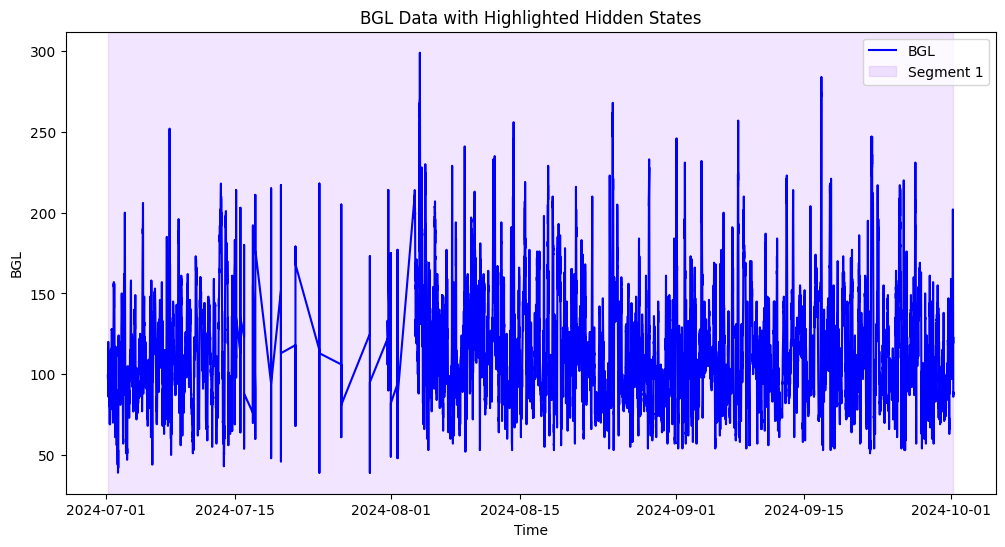

In [127]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Convert numpy array back to DataFrame
bruh = pd.DataFrame(test_smoothed, index=test_data.index, columns=['bgl'])

bruh = all_days_patient_0
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()

In [128]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse_output=False)
Y_0 = encoder.fit_transform(patients_labels[0])

In [129]:
n_components = 4
model = runGMMHMM(supervised= True, n_components=n_components, X = all_days_patient_0, n_mix = 16, n_iter = 100, Y = Y_0)

supervised


         1 -208106.80584569             +nan
         2 -195124.11404705  +12982.69179864
         3 -194398.38982028    +725.72422678
         4 -194244.13914681    +154.25067346
         5 -194172.06806365     +72.07108316
         6 -194124.84790682     +47.22015683
         7 -194087.48530639     +37.36260042
         8 -194054.86942503     +32.61588136
         9 -194024.97592561     +29.89349943
        10 -193996.88455846     +28.09136715
        11 -193970.12737188     +26.75718658
        12 -193944.45826329     +25.66910859
        13 -193919.76177295     +24.69649034
        14 -193896.00947436     +23.75229859
        15 -193873.23351111     +22.77596325
        16 -193851.50672492     +21.72678620
        17 -193830.92559167     +20.58113325
        18 -193811.59477080     +19.33082087
        19 -193793.61321348     +17.98155732
        20 -193777.06229741     +16.55091607
        21 -193761.99662659     +15.06567082
        22 -193748.43805608     +13.55857051
        23

In [130]:
hidden_states = model.predict(all_days_patient_0)

In [131]:
np.unique(hidden_states)

array([0])

39627


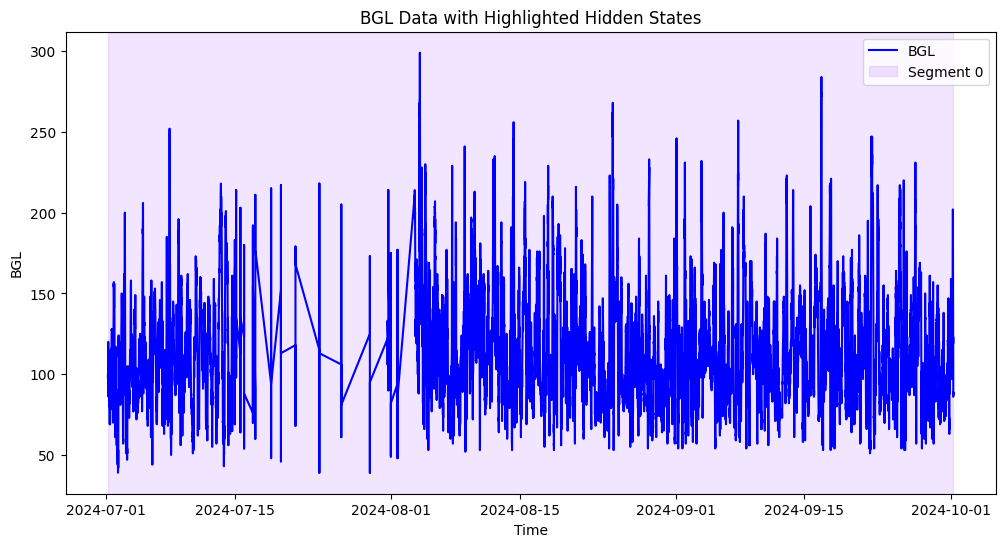

In [132]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(12, 6))


bruh = all_days_patient_0
# Plot the BGL data
plt.plot(bruh.index, bruh["bgl"], label='BGL', color='blue')

# Highlight segments based on hidden states
unique_segments = np.unique(hidden_states)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))

for segment, color in zip(unique_segments, colors):
    masks = hidden_states == segment
    print(len(masks))
    segment_indices = bruh.index[masks] 
    plt.axvspan(segment_indices.min(), segment_indices.max(),
                alpha=0.1, color=color, label=f'Segment {segment}')

# Add title and labels
plt.title("BGL Data with Highlighted Hidden States")
plt.xlabel("Time")
plt.ylabel("BGL")
plt.legend()
plt.show()